#   **Distraction Detection using MobileNetV2 with ImageNet weights**

**Importing essential libraries**

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2 # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

**Define paths to the training, testing, and validation data folders**

In [2]:
train_folder = 'data/train'
test_folder = 'data/test'
valid_folder = 'data/valid'

# Define paths to annotation files for each dataset
train_annotation_file = os.path.join(train_folder, '_annotations.txt')
test_annotation_file = os.path.join(test_folder, '_annotations.txt')
valid_annotation_file = os.path.join(valid_folder, '_annotations.txt')

# Dictionary mapping class indices to their respective class names
class_names = {
    0: 'DangerousDriving',
    1: 'Distracted',
    2: 'Drinking',
    3: 'SafeDriving',
    4: 'SleepyDriving',
    5: 'Yawn'
}

# Total number of output classes
num_classes = len(class_names)
# Target image size for resizing (MobileNetV2 input size)
target_size = (224, 224)
# Number of images per batch during training
batch_size = 32

In [3]:
def read_annotations_class_only(file_path):
    image_labels = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            image_name = parts[0]
            try:
                class_id = int(parts[1].split(',')[-1])
                if image_name not in image_labels:
                    image_labels[image_name] = class_id
            except ValueError:
                continue
    return pd.DataFrame(list(image_labels.items()), columns=['image_name', 'class_id'])

In [4]:
# Read and process annotation files for training, validation, and testing datasets
train_df = read_annotations_class_only(train_annotation_file)
valid_df = read_annotations_class_only(valid_annotation_file)
test_df = read_annotations_class_only(test_annotation_file)

# Add full image paths to each DataFrame by joining folder path with image name
train_df['image_path'] = train_df['image_name'].apply(lambda x: os.path.join(train_folder, x))
valid_df['image_path'] = valid_df['image_name'].apply(lambda x: os.path.join(valid_folder, x))
test_df['image_path'] = test_df['image_name'].apply(lambda x: os.path.join(test_folder, x))

# Convert numerical class IDs to string format (needed for Keras' `flow_from_dataframe` class_mode='categorical')
train_df['class_id_str'] = train_df['class_id'].astype(str)
valid_df['class_id_str'] = valid_df['class_id'].astype(str)
test_df['class_id_str'] = test_df['class_id'].astype(str)


**Plot one sample image from each class in the training dataset**

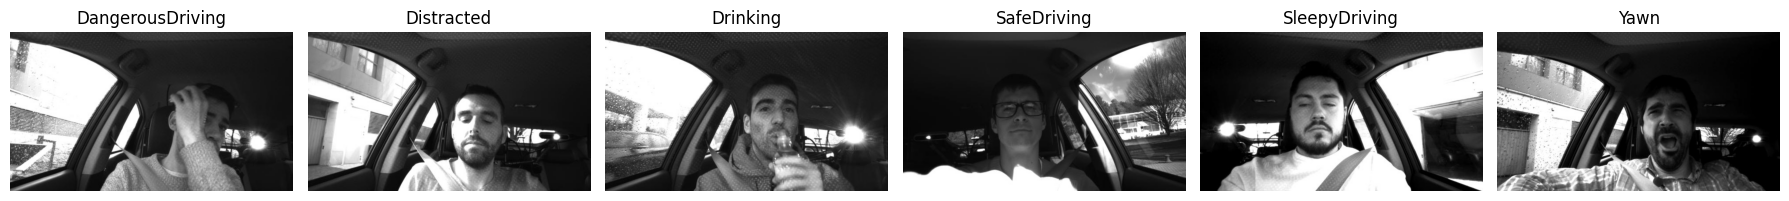

In [5]:
plt.figure(figsize=(18, 18))  # Set the figure size

# Loop over each class ID to display a sample image
for class_id in range(num_classes):
    # Select the first image corresponding to the current class
    sample_row = train_df[train_df['class_id'] == class_id].iloc[0]
    
    # Construct full image path
    image_path = os.path.join(train_folder, sample_row['image_name'])
    
    # Read and convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image in a subplot
    plt.subplot(1, num_classes, class_id + 1)
    plt.imshow(image)
    plt.title(class_names[class_id])  # Use class name as the title
    plt.axis('off')  # Hide axis for a cleaner look

# Adjust spacing between subplots and display the plot
plt.tight_layout()
plt.show()


**Calculate and display the distribution of images across each class in the training dataset**


In [6]:
# Get the count of images per class and sort by class index
class_distribution = train_df['class_id'].value_counts().sort_index()

print("Class distribution in training set:")
# Loop through each class and print its name and image count
for class_id, count in class_distribution.items():
    print(f"Class {class_id} ({class_names[class_id]}): {count} images")

Class distribution in training set:
Class 0 (DangerousDriving): 3732 images
Class 1 (Distracted): 1676 images
Class 2 (Drinking): 347 images
Class 3 (SafeDriving): 4969 images
Class 4 (SleepyDriving): 785 images
Class 5 (Yawn): 439 images


**Define data augmentation and preprocessing for training and validation/test sets**


In [7]:
# Preprocessing for validation and test datasets (only rescaling pixel values to [0, 1])
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data augmentation for training to improve model generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,                  # Normalize pixel values
    rotation_range=15,              # Random rotation up to 15 degrees
    width_shift_range=0.15,         # Random horizontal shift
    height_shift_range=0.15,        # Random vertical shift
    shear_range=0.1,                # Shear transformation
    zoom_range=0.15,                # Random zoom
    horizontal_flip=True,           # Random horizontal flipping
    brightness_range=[0.85, 1.15],  # Random brightness adjustment
    fill_mode='nearest'             # Fill in missing pixels after transforms
)

# Create training data generator from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',             # Column containing image file paths
    y_col='class_id_str',           # Column containing class labels (as strings)
    target_size=target_size,        # Resize all images to this size
    batch_size=batch_size,          # Number of images per batch
    class_mode='categorical',       # One-hot encoded labels
    shuffle=True                    # Shuffle data for training
)

# Create validation data generator
valid_generator = val_test_datagen.flow_from_dataframe(
    valid_df,
    x_col='image_path',
    y_col='class_id_str',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False                   # No shuffle for validation
)

# Create test data generator
test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='class_id_str',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False                   # No shuffle for test
)


Found 11948 validated image filenames belonging to 6 classes.
Found 1922 validated image filenames belonging to 6 classes.
Found 985 validated image filenames belonging to 6 classes.


**Define the base model using MobileNetV2 with ImageNet weights, excluding the top (classification) layer**


In [8]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a custom classifier on top of the pre-trained base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model by specifying the input (from base model) and output (predictions)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model so that they are not trainable
for layer in base_model.layers:
    layer.trainable = False

# Define the optimizer with a learning rate of 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model with categorical crossentropy loss and accuracy as the evaluation metric
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # Suitable for multi-class classification
    metrics=['accuracy']  # Track accuracy during training
)

# Print the model summary to get an overview of the architecture
# model.summary()

**Define callbacks to improve model training efficiency and prevent overfitting**


In [9]:
# Reduce learning rate when the validation loss plateaus (i.e., no improvement for 'patience' epochs)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Monitor the validation loss to decide when to reduce the learning rate
    factor=0.5,              # Reduce the learning rate by a factor of 0.5
    patience=2,              # Wait for 2 epochs without improvement before reducing the learning rate
    min_lr=1e-6,             # Set the minimum learning rate to 1e-6 to avoid going below this threshold
    verbose=1                # Print a message when the learning rate is reduced
)

# Early stopping to halt training when the validation accuracy stops improving
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy to detect overfitting
    patience=7,               # Stop after 7 epochs of no improvement
    restore_best_weights=True, # Restore the weights from the best epoch
    verbose=1                 # Print a message when training is stopped early
)

# Save the best model based on validation accuracy
model_checkpoint = ModelCheckpoint(
    'best_driver_model.keras',  # File path to save the best model
    monitor='val_accuracy',    # Monitor validation accuracy to determine the best model
    save_best_only=True,       # Save only the model with the best validation accuracy
    verbose=1                  # Print a message when the model is saved
)

# Combine all callbacks into a single list
callbacks = [reduce_lr, early_stopping, model_checkpoint]

**Training the model**

In [10]:
# Phase 1: Training with frozen base model (only the custom layers are trained)

print("Phase 1: Training with frozen base model")

# Train the model with frozen layers of the base model
history1 = model.fit(
    train_generator,           # Training data generator
    validation_data=valid_generator,  # Validation data generator
    epochs=5,                  # Train for 5 epochs
    callbacks=callbacks,       # Callbacks for learning rate reduction, early stopping, and model checkpoint
    verbose=1                  # Print progress during training
)

# Phase 2: Fine-tuning the model (unfreeze the last 50 layers of the base model)

print("Phase 2: Fine-tuning the model")

# Unfreeze the last 50 layers of the pre-trained base model for fine-tuning
for layer in base_model.layers[-50:]:  
    layer.trainable = True

# Recompile the model with a smaller learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',    # Use categorical crossentropy for multi-class classification
    metrics=['accuracy']                # Track accuracy during training
)

# Define callbacks for fine-tuning
callbacks_fine_tuning = [
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose=1),
    # Early stopping based on validation accuracy with patience of 8 epochs
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    # Save the best model based on validation accuracy
    ModelCheckpoint('best_finetuned_driver_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Fine-tune the model for 8 more epochs
history2 = model.fit(
    train_generator,           # Training data generator
    validation_data=valid_generator,  # Validation data generator
    epochs=8,                  # Train for 8 more epochs
    callbacks=callbacks_fine_tuning,  # Callbacks for fine-tuning phase
    verbose=1                  # Print progress during training
)

Phase 1: Training with frozen base model


c:\Users\dixit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.5826 - loss: 1.9148
Epoch 1: val_accuracy improved from -inf to 0.77159, saving model to best_driver_model.keras
374/374 ━━━━━━━━━━━━━━━━━━━━ 241s 636ms/step - accuracy: 0.5828 - loss: 1.9137 - val_accuracy: 0.7716 - val_loss: 1.0232 - learning_rate: 0.0010
Epoch 2/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.7434 - loss: 1.0509
Epoch 2: val_accuracy improved from 0.77159 to 0.82414, saving model to best_driver_model.keras
374/374 ━━━━━━━━━━━━━━━━━━━━ 201s 536ms/step - accuracy: 0.7435 - loss: 1.0507 - val_accuracy: 0.8241 - val_loss: 0.7568 - learning_rate: 0.0010
Epoch 3/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.7641 - loss: 0.8890
Epoch 3: val_accuracy improved from 0.82414 to 0.82518, saving model to best_driver_model.keras
374/374 ━━━━━━━━━━━━━━━━━━━━ 200s 535ms/step - accuracy: 0.7641 - loss: 0.8890 - val_accuracy: 0.8252 - val_loss: 0.6643 - learning_rate: 0.0010
Epoch 4/5
374/374 ━

**Save the trained model to a file in the H5 format**

In [11]:
model.save('distraction_detection_model.h5')  # Save the entire model (architecture, weights, optimizer, etc.)
print("Model saved as 'distraction_detection_model.h5'")

Model saved as 'distraction_detection_model.h5'


**Evaluate the model's performance on the test set**

In [12]:
print("Evaluating model on test set:")
# Evaluate the model using the test data generator
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

Evaluating model on test set:
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 344ms/step - accuracy: 0.9445 - loss: 0.3209
Test Accuracy: 0.9381


**Plot training and validation loss and accuracy over all epochs for both training phases**


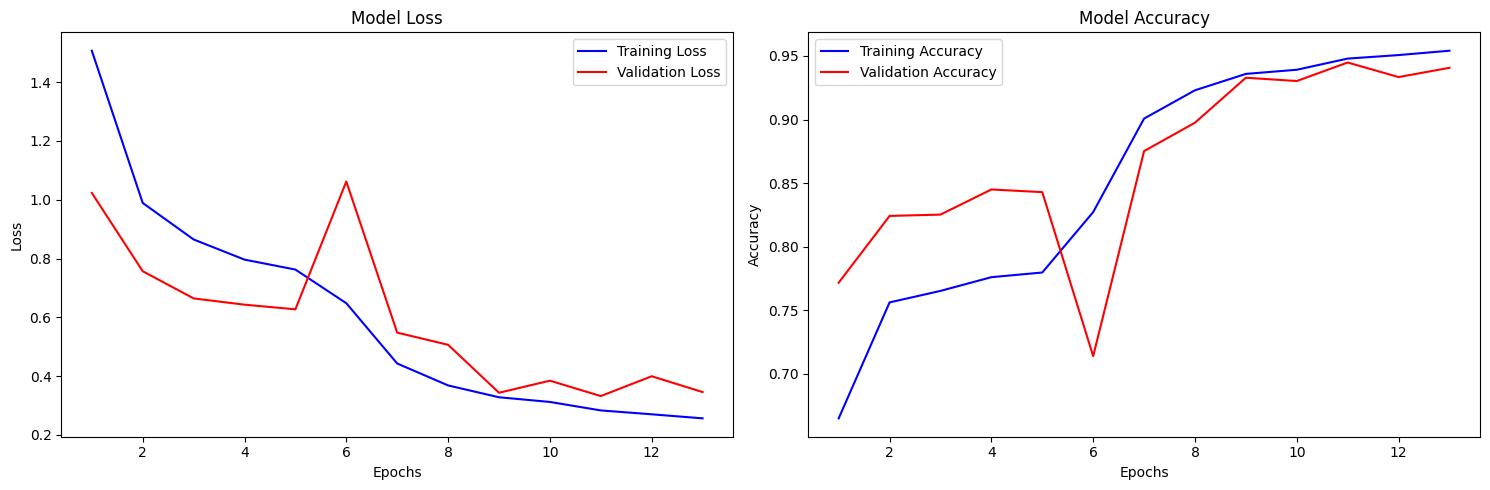

In [14]:
plt.figure(figsize=(15, 5))  # Set figure size for the plot

# Subplot 1: Model Loss
plt.subplot(1, 2, 1)  # Create the first subplot (1 row, 2 columns, this is the first plot)
all_epochs = range(1, len(history1.history['loss']) + len(history2.history['loss']) + 1)  # All epochs combined
all_train_loss = history1.history['loss'] + history2.history['loss']  # Training loss over both phases
all_val_loss = history1.history['val_loss'] + history2.history['val_loss']  # Validation loss over both phases
plt.plot(all_epochs, all_train_loss, 'b-', label='Training Loss')  # Plot training loss in blue
plt.plot(all_epochs, all_val_loss, 'r-', label='Validation Loss')  # Plot validation loss in red
plt.title('Model Loss')  # Title of the loss plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  # Show legend

# Subplot 2: Model Accuracy
plt.subplot(1, 2, 2)  # Create the second subplot (1 row, 2 columns, this is the second plot)
all_train_acc = history1.history['accuracy'] + history2.history['accuracy']  # Training accuracy over both phases
all_val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']  # Validation accuracy over both phases
plt.plot(all_epochs, all_train_acc, 'b-', label='Training Accuracy')  # Plot training accuracy in blue
plt.plot(all_epochs, all_val_acc, 'r-', label='Validation Accuracy')  # Plot validation accuracy in red
plt.title('Model Accuracy')  # Title of the accuracy plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Show legend

plt.tight_layout()  # Adjust layout to prevent overlap of plots
plt.show()  # Display the plots

**Function to visualize model predictions on sample test images**


Visualizing sample predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


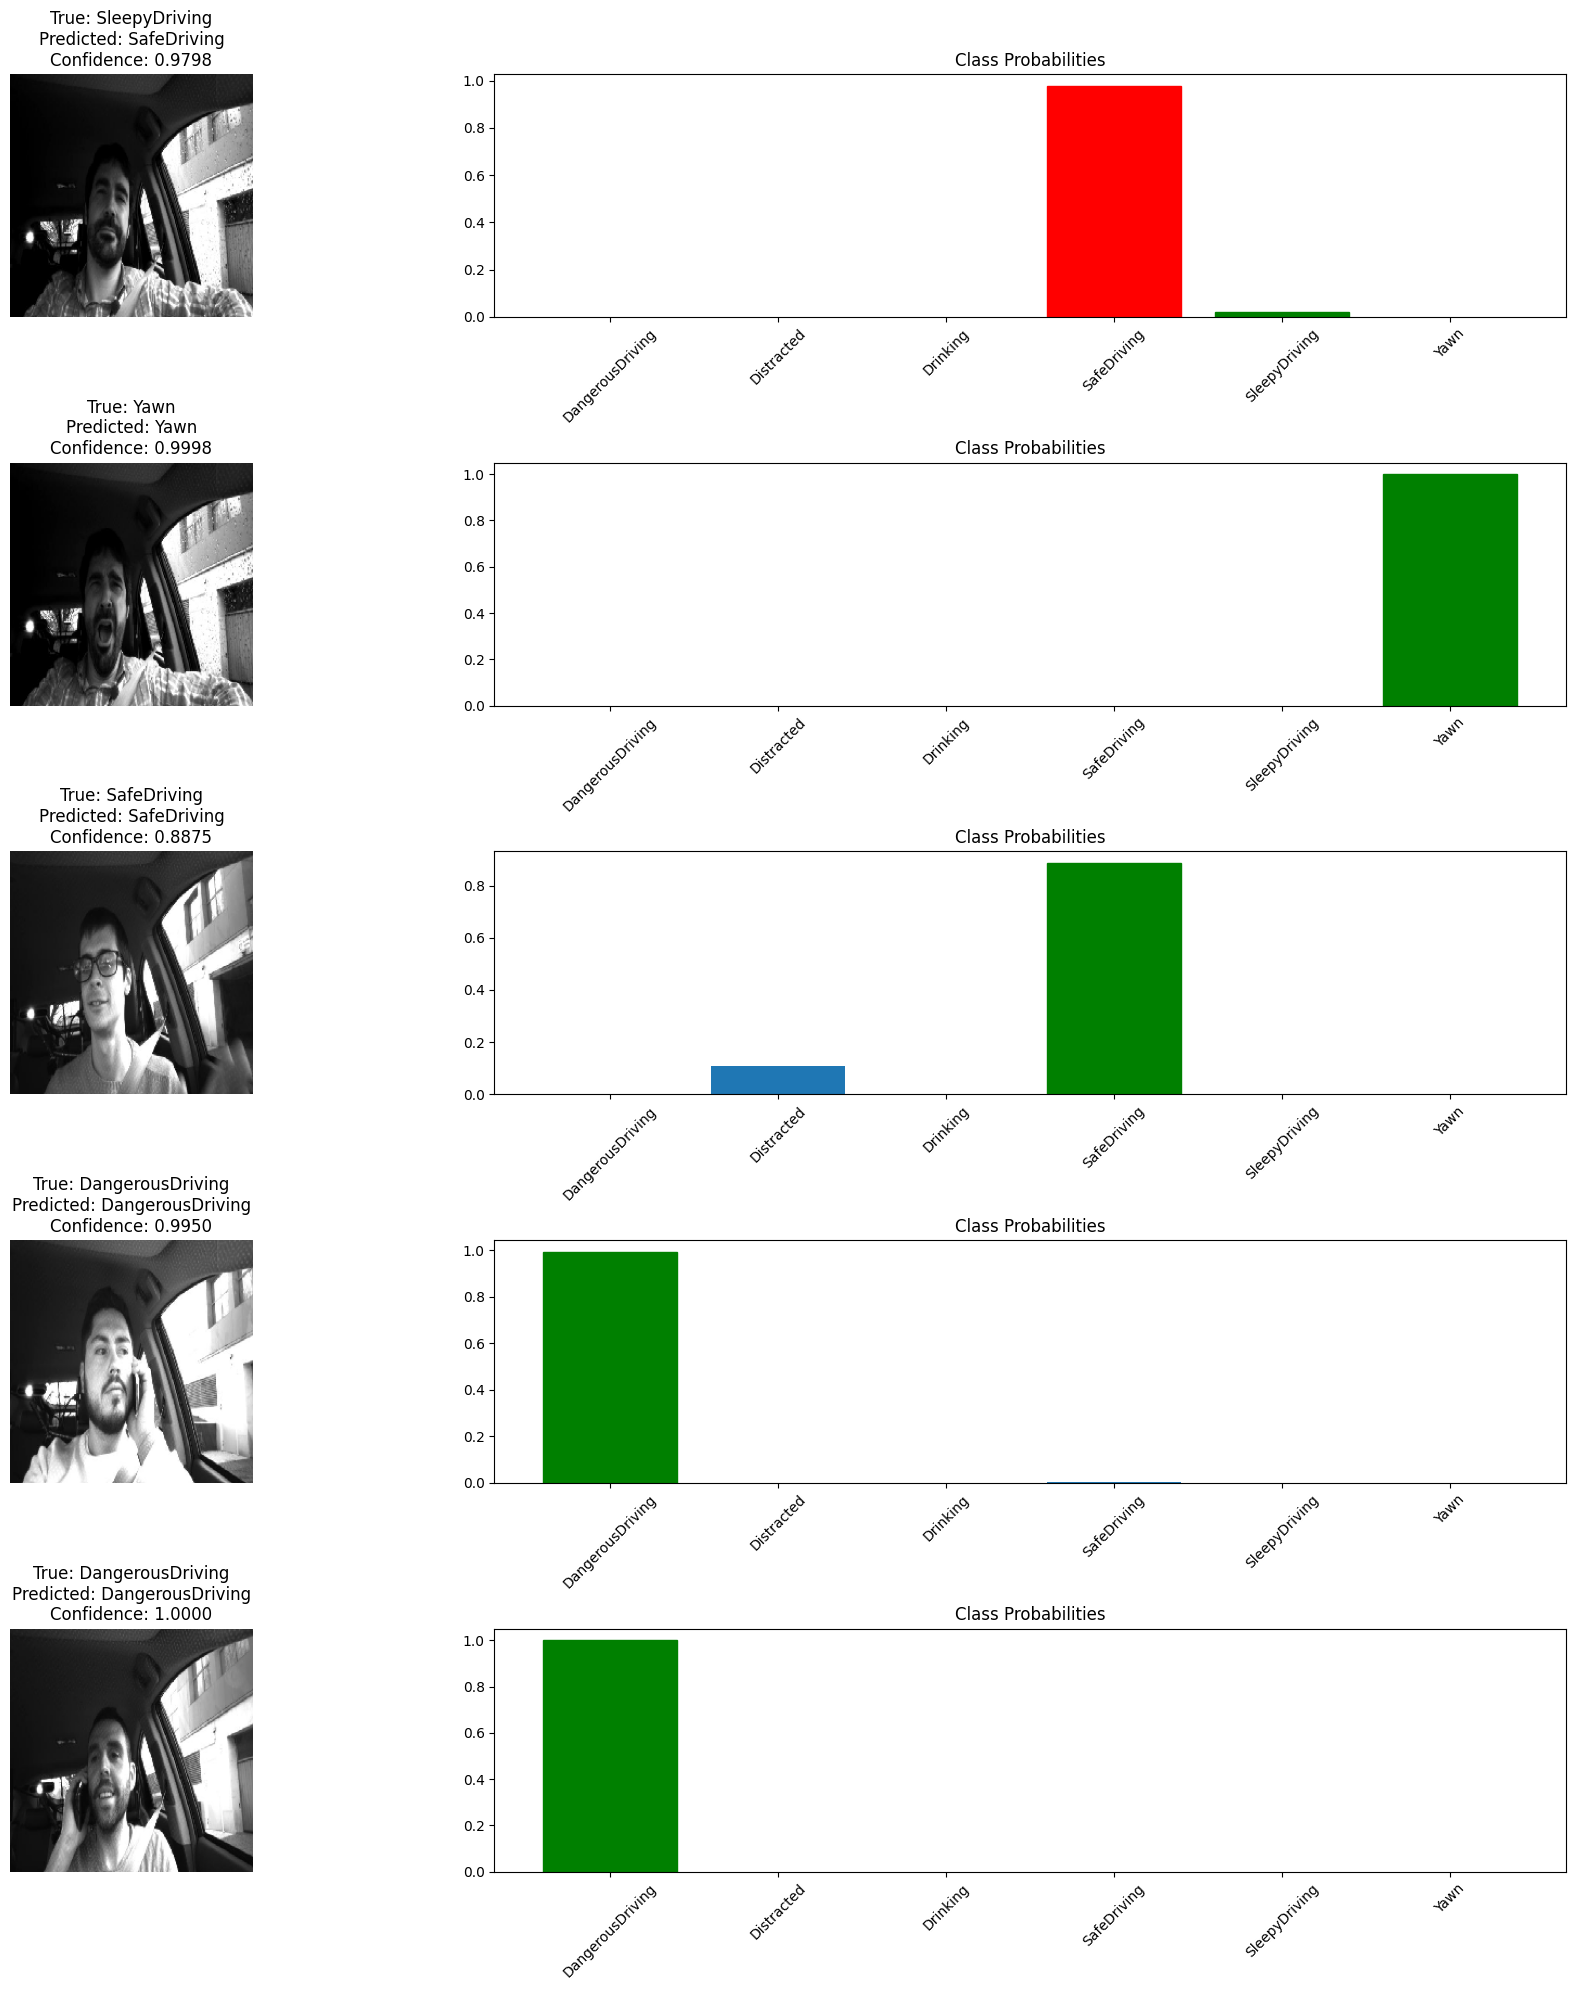

In [15]:
def visualize_prediction(model, test_generator, class_names, num_samples=5):
    # Get a batch of images and labels from the test generator
    images, labels = next(test_generator)
    
    # Make predictions for the batch of images
    predictions = model.predict(images)
    
    # Create a figure with subplots to display predictions and class probabilities
    plt.figure(figsize=(20, 4 * num_samples))  # Set the figure size for multiple samples
    
    # Loop through the samples to plot predictions
    for i in range(min(num_samples, len(images))):
        # Get the true class and predicted class for each sample
        true_class = np.argmax(labels[i])  # True class (max value in label)
        pred_class = np.argmax(predictions[i])  # Predicted class (max value in prediction)
        confidence = predictions[i][pred_class]  # Confidence of the predicted class
        
        # Plot the image with the true and predicted class labels
        plt.subplot(num_samples, 2, 2*i+1)  # Create subplot for the image
        plt.imshow(images[i])  # Display the image
        plt.title(f"True: {class_names[true_class]}\nPredicted: {class_names[pred_class]}\nConfidence: {confidence:.4f}")  # Title with true label, predicted label, and confidence
        plt.axis('off')  # Turn off axis for clarity
        
        # Plot the class probabilities for each image
        plt.subplot(num_samples, 2, 2*i+2)  # Create subplot for the bar chart
        bars = plt.bar(range(len(class_names)), predictions[i])  # Bar chart for class probabilities
        plt.xticks(range(len(class_names)), [class_names[j] for j in range(len(class_names))], rotation=45)  # Class names on x-axis
        plt.title("Class Probabilities")  # Title for the probability plot
        
        # Highlight the true class in green and the predicted class in red
        bars[true_class].set_color('green')  # Green for the true class
        if pred_class != true_class:  # If the predicted class is wrong, highlight it in red
            bars[pred_class].set_color('red')
    
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()  # Display the plots

# Visualizing predictions for sample test images
print("Visualizing sample predictions:")
visualize_prediction(model, test_generator, class_names)
